In [1]:
import numpy as np
import heapq as hq
import numba
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)
N = 20
mat_A = np.random.randint(2, size=(N, N))
mat_A = (mat_A + mat_A.T) -1

mat_A[mat_A<0] = 0

d = np.dot(mat_A, np.ones(N))
M = np.matmul(mat_A, np.diag(1/d))
q = np.zeros(N)
q[0] = 1
p = np.dot(np.linalg.inv((.85*np.eye(N)-(1-.85)*M)/(1-.85)), q)

#print(p)

nzs = np.nonzero(np.triu(mat_A))
edgelist = [(a,b) for a,b in zip(nzs[0], nzs[1])]

In [3]:
edge_dict = {}
for edge in edgelist:
    if edge[0] in edge_dict:
        edge_dict[edge[0]].append(edge[1])
    else:
        edge_dict[edge[0]] = [edge[1]]
    if edge[0] != edge[1]:
        if edge[1] in edge_dict:
            edge_dict[edge[1]].append(edge[0])
        else:
            edge_dict[edge[1]] = [edge[0]]

In [4]:
N = max(edge_dict.keys())+1
A = [[]]*N

for n in range(N):
    if n in edge_dict:
        A[n] = edge_dict[n]

In [5]:
#A

In [6]:
# the function performs a push operation
def push(p, r, alpha, u, du, neighbours, neighbours_deg, epsilon):
    
    # update the vectors (they are passed as pointers)
    p[u] += alpha*r[u]
    r[u] *= (1.0 - alpha)/2.
    
    # initialize the indicator list that tells
    # approximate pagerank which node needs to be 
    # added into the priority queue for the next
    # iteration of the algorithm
    r_above_th = [False]*len(neighbours)
    
    # update r again and define the values 
    # of the indicator list
    for i, n in enumerate(neighbours):
        r[n] += (1.0 - alpha)*r[u]/(2.0*du)
        # a node v must be added if: r(v)/d(v) >= epsilon
        if (neighbours_deg[i] == 0 and r[0] != 0) or r[n]/neighbours_deg[i] >= epsilon:
            r_above_th[i] = True
            
    return r_above_th

In [7]:
def approximate_page_rank(A, v, alpha, epsilon):
    # compute N
    N = len(A)
    
    # initialize the approximate PageRank vectors
    p = np.zeros(N)
    r = np.zeros(N)
    r[v] = 1
    
    # for some reason pyhton decided to create a min pq
    # so we push the cost inverted (in this case d/1 = d)
    pq = []
    hq.heappush(pq, (len(A[v]), v))
    
    # precompute the inverse of epsilon for efficiency
    inv_epsilon = 1/epsilon
    
    # iterate over the heap as per defined in [1]
    while len(pq)>0 and pq[0][0] <= inv_epsilon:
        u = hq.heappop(pq)[1]
        neigh = A[u]
        
        # compute the degrees of the neighbours
        neigh_deg = [0]*len(neigh)
        for i, n in enumerate(neigh):
            neigh_deg[i] = len(A[n])
        
        # call the push function to update p and r and
        # to get the list of neighbours to add to the pq
        r_above_th = push(p, r, alpha, u, len(neigh), neigh, neigh_deg, epsilon)
        
        # push the new nodes accordingly to the indicator
        # vector r_above_th returned by push (boolean)
        for i, flag in enumerate(r_above_th):
            if flag:
                # there can never be a math exception, since if r were
                # to be 0 then it would have never been inserted in the list
                hq.heappush(pq, (neigh_deg[i]/r[neigh[i]], neigh[i]))
                
    # return p
    return p

In [8]:
#approximate_page_rank([[1, 2], [0, 2], [0, 1]], 0, .5, .0000000001)
p1 = approximate_page_rank(A, 0, .85, .0000001)

In [13]:
print(np.linalg.norm(p - p1))
print(np.correlate(p/np.sum(p), p1/np.sum(p1)))

0.7411296277316075
[0.82516464]


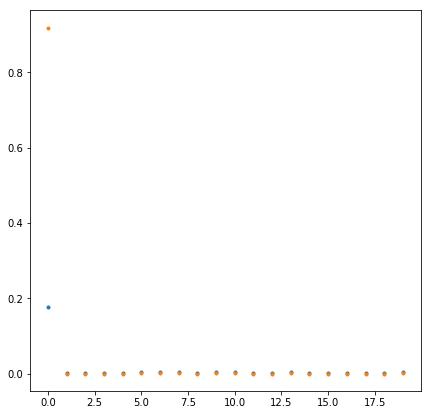

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(7,7))
axs.plot(p, '.')
axs.plot(p1, '.')

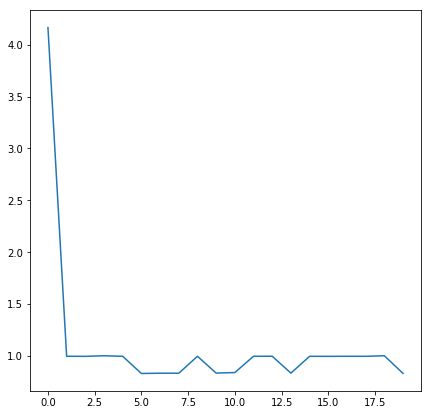

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(7,7))
axs.plot(np.abs(p-p1)/p)